### Imports, loading features and DB

In [1]:
# improve speed of SVC in sklearn
from sklearnex import patch_sklearn
patch_sklearn("SVC")

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import sys
sys.path.insert(0, '../..')

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from metrics.metrics_utils import get_froc_df_of_many_imgs_features
from metrics.metrics import froc_curve
from general_utils.plots import plot_froc
import seaborn as sns
from database.dataset import *
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

# set the seed for reproducible execution
rseed = np.random.seed(42)


In [4]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15)

Load the features data

In [5]:
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria

In [6]:
features_data = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/all_data_df.f')
fnsdf = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/fns_df.f')
ignored = pd.read_feather('/home/vzalevskyi/projects/data/features/morph/ingnored_df.f')

In [7]:
# retrieving each features set column names

fos_cols = [x for x in features_data if 'img' in x and x != 'img_id']
gabor_cols = [x for x in features_data if 'gabor_' in x]
wavelet_cols = [x for x in features_data if x[:6]
                == 'patch_' and x != 'patch_coordinates']
haar_cols = [x for x in features_data if 'haar' in x]

features_sets = {'fos': fos_cols, 'gabor': gabor_cols, 'wavelet': wavelet_cols,
                 'haar': haar_cols,
                 'all_features': fos_cols+gabor_cols+wavelet_cols+haar_cols}


# Grid-Search

In [8]:
param_grid = [
    {'SVC__C': [1, 10, 100], 'SVC__kernel': ['linear']},
    {'SVC__C': [1, 10, 100, ], 'SVC__degree':[
        3, 5, 7, 10], 'SVC__kernel': ['poly']},
    {'SVC__C': [1, 10, 100, ], 'SVC__gamma': [
                0.01, 0.1, 1, 'scale'], 'SVC__kernel': ['rbf']},
]


pipe = Pipeline([('scaler', MinMaxScaler()), ('SVC', SVC())])


clf = GridSearchCV(estimator=pipe,
                   param_grid=param_grid,
                   scoring='roc_auc',
                   n_jobs=8,
                   cv=5)


FP2TP_rate = 10
positive_mask = (features_data.label > 0)
positive_train_part = features_data[positive_mask]
negative_train_part = features_data[~positive_mask].sample(
    FP2TP_rate*positive_mask.sum())
train_df = pd.concat(
    [positive_train_part, negative_train_part]).sample(frac=1.)
train_y = train_df.label
train_X = train_df[features_sets['all_features']]

clf.fit(train_X, train_y)


/home/vzalevskyi/anaconda3/envs/calc_det/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('SVC', SVC())]),
             n_jobs=8,
             param_grid=[{'SVC__C': [1, 10, 100], 'SVC__kernel': ['linear']},
                         {'SVC__C': [1, 10, 100], 'SVC__degree': [3, 5, 7, 10],
                          'SVC__kernel': ['poly']},
                         {'SVC__C': [1, 10, 100],
                          'SVC__gamma': [0.01, 0.1, 1, 'scale'],
                          'SVC__kernel': ['rbf']}],
             scoring='roc_auc')

In [13]:
clf.best_params_

{'SVC__C': 10, 'SVC__gamma': 0.1, 'SVC__kernel': 'rbf'}

# Cascade

In [8]:
svc_params = {'C': 10,
             'gamma': 0.1,
             'kernel': 'rbf',
             'probability':True
        }
first_stage_model = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(**svc_params))])
second_stage_model = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(**svc_params))])

In [9]:
# adding case_id column for case_wise K-fold CV splits
imgid2caseid = db.df[['img_id', 'case_id']].set_index('img_id').to_dict()['case_id']
features_data['case_id'] = [imgid2caseid[imgid] for imgid in features_data['img_id']]

In [10]:
features = features_sets['all_features']

In [11]:
# splitting all candidates between db train and validation partitions

all_train_db_ids = db.df[db.df.partition == 'train'].img_id.values
all_valid_db_ids = db.df[db.df.partition == 'validation'].img_id.values

general_train_mask = features_data.img_id.isin(all_train_db_ids)
general_valid_mask = features_data.img_id.isin(all_valid_db_ids)

train_features = features_data[general_train_mask]
test_features = features_data[general_valid_mask]

train_fnsd = fnsdf[fnsdf.img_id.isin(all_train_db_ids)]

### Frist stage

In [12]:
FP2TP_rate = 10

# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (train_features.label > 0)
positive_train_part = train_features[positive_mask]
negative_train_part = train_features[~positive_mask].sample(FP2TP_rate*positive_mask.sum())

train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)


train_y = train_df.label
test_y = test_features.label


first_stage_model.fit(train_df[features], train_df.label)


all_train_y_predicted = first_stage_model.predict_proba(train_features[features])[:, 1]
all_test_y_predicted = first_stage_model.predict_proba(test_features[features])[:, 1]

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


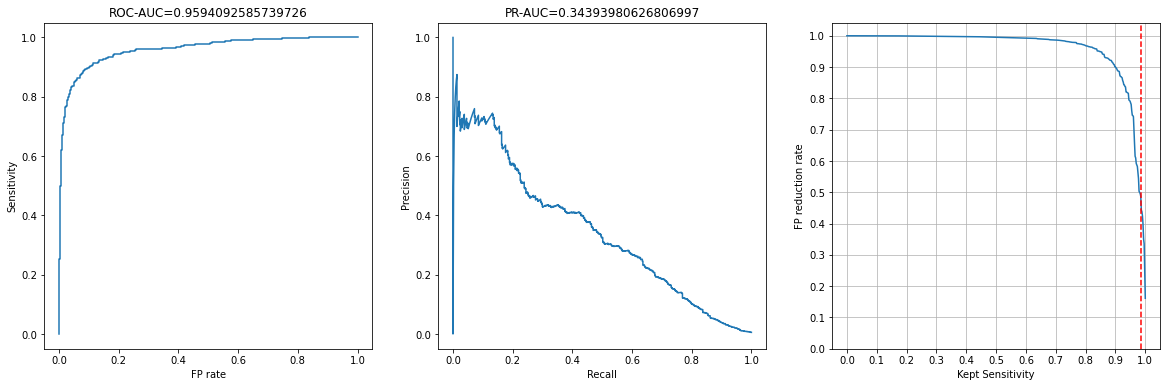

In [13]:
fpr, tpr, thrs = roc_curve(test_features.label,
                           all_test_y_predicted)

prc, rc, thrs_pr = precision_recall_curve(
    test_features.label, all_test_y_predicted)

filtered_fp_prc = []
total_fp = np.sum(~test_features.label)
for ks in sorted(tpr):

    max_conf_thr_required = thrs[np.argmax(tpr >= ks)]

    filtered_fp = np.sum((~test_features.label) & (
        all_test_y_predicted <= max_conf_thr_required))/total_fp
    filtered_fp_prc.append(filtered_fp)
    
    
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].plot(fpr, tpr)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(
    f'ROC-AUC={roc_auc_score(test_features.label, all_test_y_predicted)}')

axs[1].plot(rc, prc)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc, prc)}')

axs[2].plot(tpr, filtered_fp_prc)
axs[2].set_xlabel('Kept Sensitivity')
axs[2].set_ylabel('FP reduction rate')
axs[2].grid(which='major', alpha=0.9)
axs[2].axvline(0.986, color = 'r', linestyle = '--')
axs[2].set_xticks(np.arange(min(tpr), max(tpr)+0.1, 0.1))
axs[2].set_yticks(np.arange(0, 1.1, 0.1))

plt.show()


In [14]:
cascade1_tpr = tpr.copy()
cascade1_thrs = thrs.copy()
cascade1_labels = test_features.label.values
cascade1_probas = all_test_y_predicted

keep_sens_thr = .98
max_conf_thr_required = cascade1_thrs[np.argmax(cascade1_tpr >= keep_sens_thr)]

filtered_fp = np.sum((~cascade1_labels) & (
    cascade1_probas <= max_conf_thr_required))/total_fp


msg = (
    f"Selected keep_sens_thr={keep_sens_thr}\n"
    f'max_conf_thr_required to keep given sensitivity is {max_conf_thr_required:.5f}\n'
    f'Filtering out all candidates with confidence <={max_conf_thr_required:.5f} is estimated to reduce FP by {100*filtered_fp:.2f} %'
)
print(msg)

Selected keep_sens_thr=0.98
max_conf_thr_required to keep given sensitivity is 0.00350
Filtering out all candidates with confidence <=0.00350 is estimated to reduce FP by 49.58 %


In [15]:
train_df_stage2 = train_features[all_train_y_predicted>max_conf_thr_required]
print(len(train_features), len(train_df_stage2))
test_df_stage2 = test_features[all_test_y_predicted>max_conf_thr_required]
print(len(test_features), len(test_df_stage2))

236368 123766
117464 59473


## Second stage

In [16]:
test_df_stage2.label.value_counts()

False    58956
True       517
Name: label, dtype: int64

In [17]:
ens_size = 5
FP2TP_rate = 10
second_stage_ensemble = [Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(**svc_params))]) for _ in range(ens_size)]
second_stage_ens_pred = np.zeros(len(test_df_stage2))

positive_mask = (train_df_stage2.label > 0)
positive_train_part = train_df_stage2[positive_mask]
negative_train_part_all = train_df_stage2[~positive_mask].sample(frac=1.0)
sampling_idx = np.array_split(np.arange(len(negative_train_part_all)) , ens_size)

In [ ]:
for ens_idx in tqdm(range(ens_size)):
    negative_train_part = negative_train_part_all.iloc[sampling_idx[ens_idx]]
    ens_train_df = pd.concat([positive_train_part, negative_train_part])
    second_stage_ensemble[ens_idx].fit(ens_train_df[features],
                                      ens_train_df.label)
    second_stage_ens_pred += second_stage_ensemble[ens_idx].predict_proba(test_df_stage2[features])[:, 1]

In [19]:
second_stage_ens_pred = second_stage_ens_pred/ens_size

In [19]:
FP2TP_rate = 10

# and sampling to a predefined 1:FP2TP_rate TP:FP samples
positive_mask = (train_df_stage2.label > 0)
positive_train_part = train_df_stage2[positive_mask]
negative_train_part = train_df_stage2[~positive_mask].sample(FP2TP_rate*positive_mask.sum())

train_df = pd.concat([positive_train_part, negative_train_part]).sample(frac=1.)

second_stage_model.fit(train_df[features], train_df.label)


all_train_y_predicted2 = second_stage_model.predict_proba(train_df_stage2[features])[:, 1]
all_test_y_predicted2 = second_stage_model.predict_proba(test_df_stage2[features])[:, 1]

INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.fit: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


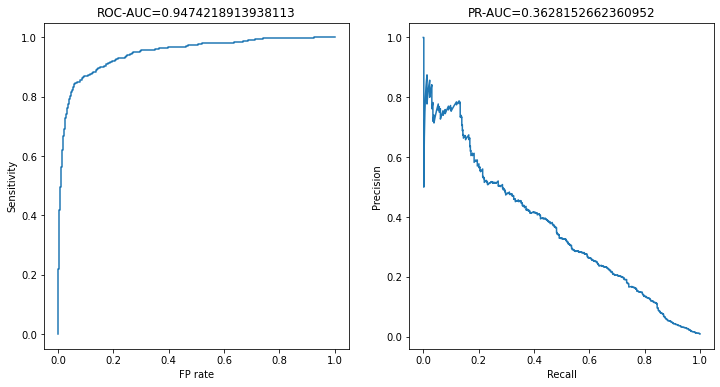

In [21]:
fpr2, tpr2, thrs2 = roc_curve(test_df_stage2.label,
                           second_stage_ens_pred)

prc2, rc2, thrs_pr2 = precision_recall_curve(
    test_df_stage2.label, second_stage_ens_pred)

filtered_fp_prc2 = []
total_fp2 = np.sum(~test_df_stage2.label)

    
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(fpr2, tpr2)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title(
    f'ROC-AUC={roc_auc_score(test_df_stage2.label, second_stage_ens_pred)}')

axs[1].plot(rc2, prc2)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'PR-AUC={auc(rc2, prc2)}')


plt.show()


## Comparison

In [22]:
max_conf_thr_required

0.003498753519033348

In [20]:
val1st_pred = first_stage_model.predict_proba(test_features[features])[:, 1]
test_features_cascaded = test_features[val1st_pred>max_conf_thr_required]
print(len(test_features), len(test_features_cascaded))

INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


117464 59473


In [21]:
val2st_pred = second_stage_model.predict_proba(test_features[features])[:, 1]
val2st_casc_pred = second_stage_model.predict_proba(test_features_cascaded[features])[:, 1]
print(len(val2st_pred), len(val2st_casc_pred))

INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU


117464 59473


In [23]:
# adding lost TP (due to drop of easy negatives) as additional FN
stag1_droped_easy_neg = test_features[val1st_pred <= max_conf_thr_required]
stag1_droped_easy_neg = stag1_droped_easy_neg[stag1_droped_easy_neg.label]
stag1_droped_easy_neg['label'] = 'FN'
stag1_droped_easy_neg['repeted_idxs'] = False


stag1_droped_easy_neg['x'] = [x[0] for x in stag1_droped_easy_neg.candidate_coordinates.values]
stag1_droped_easy_neg['y'] = [x[1] for x in stag1_droped_easy_neg.candidate_coordinates.values]
stag1_droped_easy_neg['radius'] = [x[2] for x in stag1_droped_easy_neg.candidate_coordinates.values]

valid_fnsdf = fnsdf[fnsdf.img_id.isin(test_features.img_id.unique())]
cascaded_fns = pd.concat([stag1_droped_easy_neg, valid_fnsdf])

In [24]:
print(len(stag1_droped_easy_neg), len(valid_fnsdf))

11 136


In [26]:
normal_imgs_ids = db.get_normal_imgs_ids()

froc_df_1st = get_froc_df_of_many_imgs_features(
    test_features[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val1st_pred,
    normal_imgs_ids
)

sens1, avgs_fp_per_image1, _ = froc_curve(
    froc_df_1st, non_max_supression=True, cut_on_50fpi=True)


froc_df_2st = get_froc_df_of_many_imgs_features(
    test_features_cascaded[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    second_stage_ens_pred,
    normal_imgs_ids
)

sens2, avgs_fp_per_image2, _ = froc_curve(
    froc_df_2st, non_max_supression=True, cut_on_50fpi=True)


froc_df_cascade = get_froc_df_of_many_imgs_features(
    test_features_cascaded[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    valid_fnsdf,
    val2st_casc_pred,
    normal_imgs_ids
)

sens_casc, avgs_fp_per_image_casc, _ = froc_curve(
    froc_df_cascade, non_max_supression=True, cut_on_50fpi=True)

/home/vzalevskyi/projects/calc-det/notebooks/experiments/../../metrics/metrics_utils.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fns_df.loc[:, 'detection_labels'] = 'FN'
/home/vzalevskyi/projects/calc-det/notebooks/experiments/../../metrics/metrics_utils.py:524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fns_df.loc[:, 'pred_scores'] = 0.
/home/vzalevskyi/projects/calc-det/notebooks/experiments/../../metrics/metrics_utils.py:525: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

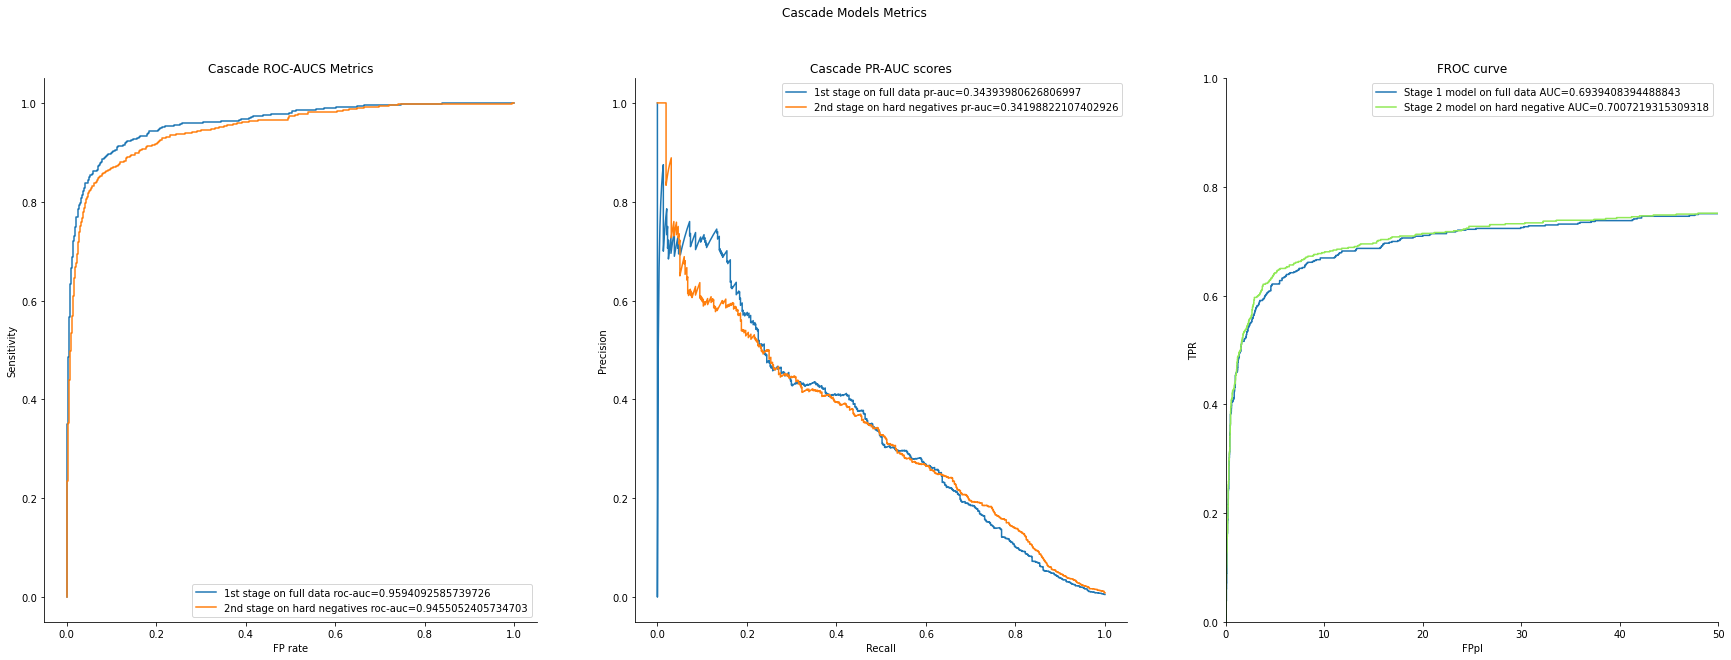

In [30]:
fpr_train1, tpr_train1, _ = roc_curve(test_features.label, val1st_pred)
prc_train1, rc_train1, _ = precision_recall_curve(
    test_features.label, val1st_pred)

fpr_test2, tpr_test2, _ = roc_curve(test_features_cascaded.label, second_stage_ens_pred)
prc_test2, rc_test2, _ = precision_recall_curve(
    test_features_cascaded.label, second_stage_ens_pred)

fpr_test3, tpr_test3, _ = roc_curve(test_features_cascaded.label, val2st_casc_pred)
prc_test3, rc_test3, _ = precision_recall_curve(
    test_features_cascaded.label, val2st_casc_pred)


fig, axs = plt.subplots(1, 3, figsize=(30, 10))
fig.suptitle('Cascade Models Metrics')
axs[0].plot(fpr_train1, tpr_train1)
# axs[0].plot(fpr_test2, tpr_test2)
axs[0].plot(fpr_test3, tpr_test3)
axs[0].set_xlabel('FP rate')
axs[0].set_ylabel('Sensitivity')
axs[0].set_title('Cascade ROC-AUCS Metrics')
axs[0].legend([f'1st stage on full data roc-auc={roc_auc_score(test_features.label, val1st_pred, )}',
            #    f'2nd stage ensebmle roc-auc={roc_auc_score(test_features_cascaded.label, second_stage_ens_pred)}',
               f'2nd stage on hard negatives roc-auc={roc_auc_score(test_features_cascaded.label, val2st_casc_pred)}'])

axs[1].plot(rc_train1, prc_train1)
# axs[1].plot(rc_test2, prc_test2)
axs[1].plot(rc_test3, prc_test3)
axs[1].set_xlabel('Recall')
axs[1].set_ylabel('Precision')
axs[1].set_title(f'Cascade PR-AUC scores')
axs[1].legend([f'1st stage on full data pr-auc={auc(rc_train1, prc_train1)}',
            #    f'2nd stage on ensemble={auc(rc_test2, prc_test2)}',
               f'2nd stage on hard negatives pr-auc={auc(rc_test3, prc_test3)}'])



plot_froc(avgs_fp_per_image1, sens1, cut_on_50fpi=True,
          ax=axs[2], color=(0.12, 0.46, 0.7, 1.0))


# plot_froc(avgs_fp_per_image2, sens2,
#           cut_on_50fpi=True, ax=axs[2], color=(0.1, 0.49, 0.07, 1.0))


plot_froc(avgs_fp_per_image_casc, sens_casc,
          cut_on_50fpi=True, ax=axs[2], color=(0.569944, 0.914625, 0.341379, 1.0))


avgs_fp_per_image1 = np.asarray(avgs_fp_per_image1)
avgs_fp_per_image2 = np.asarray(avgs_fp_per_image2)
avgs_fp_per_image3 = np.asarray(avgs_fp_per_image_casc)
axs[2].legend([f'Stage 1 model on full data AUC={auc(avgs_fp_per_image1/avgs_fp_per_image1.max(), sens1)}',
            #    f'Stage 2 model ensemble data AUC={auc(avgs_fp_per_image2/avgs_fp_per_image2.max(), sens2)}',
               f'Stage 2 model on hard negative AUC={auc(avgs_fp_per_image3/avgs_fp_per_image3.max(), sens_casc)}'])
plt.show()


In [25]:
with open('/home/vzalevskyi/projects/data/cascade/cascade_models.pkl', 'wb') as f:
    pickle.dump((first_stage_model, second_stage_model, 
                 cascade1_tpr, cascade1_thrs, 
                 cascade1_labels, cascade1_probas,
                 keep_sens_thr), f)